In [58]:
import warnings
warnings.filterwarnings('ignore')

import numpy
import iris
import iris.plot as iplt
import matplotlib.pyplot as plt

import os, sys
cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

import convenient_universal as uconv
import spatial_weights
import timeseries

In [59]:
%matplotlib inline

In [60]:
soga_file = '/g/data/ua6/DRSv3/CMIP5/CSIRO-Mk3-6-0/piControl/mon/ocean/r1i1p1/soga/latest/soga_Omon_CSIRO-Mk3-6-0_piControl_r1i1p1_000101-050012.nc'
wfo_file = '/g/data/ua6/DRSv3/CMIP5/CSIRO-Mk3-6-0/piControl/mon/ocean/r1i1p1/wfo/latest/wfo_Omon_CSIRO-Mk3-6-0_piControl_r1i1p1_000101-050012.nc'
area_file = '/g/data/ua6/DRSv3/CMIP5/CSIRO-Mk3-6-0/piControl/fx/ocean/r0i0p0/areacello/latest/areacello_fx_CSIRO-Mk3-6-0_piControl_r0i0p0.nc'

## Global mean sea water salinity

In [61]:
soga_cube = iris.load_cube(soga_file)
soga_cube = timeseries.convert_to_annual(soga_cube)

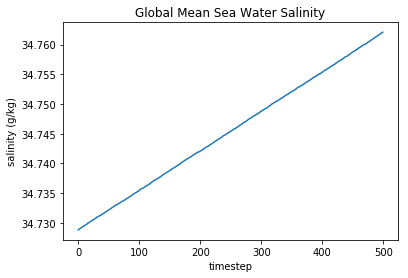

In [62]:
plt.plot(soga_cube.data)
plt.xlabel('timestep')
plt.ylabel('salinity (g/kg)')
plt.title(soga_cube.long_name)
plt.show()

## Water flux into sea water

This variable represents the net freshwater flux at the ocean surface. In other words, it is the sum of the rainfall flux, snowfall flux, evaporation flux, river runoff and water flux from icebergs.

It's worth noting how freshwater fluxes are represented differently across models, with some models converting the freshwater flux to a virtual salt flux (so that the volume of the ocean stays the same). [This paper](https://www.sciencedirect.com/science/article/pii/S2095927317300932) gives a good overview.

In [70]:
wfo_cube = iris.load_cube(wfo_file)
wfo_cube = timeseries.convert_to_annual(wfo_cube)
wfo_cube

<iris 'Cube' of water_flux_into_sea_water / (kg m-2 s-1) (time: 500; latitude: 189; longitude: 192)>

In [71]:
area_cube = iris.load_cube(area_file)
area_array = uconv.broadcast_array(area_cube.data, [1, area_cube.ndim], wfo_cube.shape)
print(area_array.shape)

(500, 189, 192)


The units need to be converted from $kg\; m^{-2}\; s^{-1}$ to $kg$ in order to be able to work effectively with the salinity data (which is $g/kg$).

In [72]:
# Remove the m-2
units = str(wfo_cube.units)
wfo_cube.units = units.replace('m-2', '')
wfo_cube.data = wfo_cube.data * area_array

# Calculate the global sum
wfo_cube = wfo_cube.collapsed(['latitude', 'longitude'], iris.analysis.SUM, weights=area_array)
wfo_cube.remove_coord('latitude')
wfo_cube.remove_coord('longitude')

# Remove the s-1
assert 'days' in str(wfo_cube.coord('time').units)
time_span_days = wfo_cube.coord('time').bounds[:, 1] - wfo_cube.coord('time').bounds[:, 0]
time_span_seconds = time_span_days * 60 * 60 * 24
wfo_cube.data = wfo_cube.data * time_span_seconds
units = str(wfo_cube.units)
wfo_cube.units = units.replace('s-1', '')

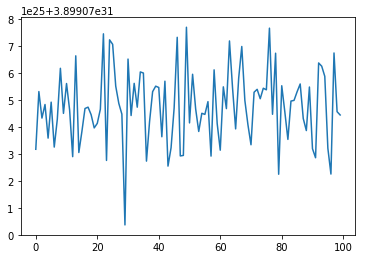

In [74]:
plt.plot(wfo_cube.data[0:100])
plt.show()

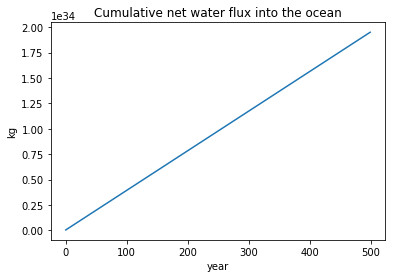

In [75]:
cumsum = numpy.cumsum(wfo_cube.data)
plt.plot(cumsum)
plt.title("Cumulative net water flux into the ocean")
plt.xlabel('year')
plt.ylabel(wfo_cube.units)
plt.show()

[In the CNRM-CM5 model wfo variable is positive upwards](http://www.umr-cnrm.fr/cmip5/spip.php?article24). I wonder if that's the case for other models?